In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.describe()

,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


### Data preprocessing

In [7]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [8]:
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)

In [9]:
df.dropna(inplace=True)

In [13]:
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=False)

In [15]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [17]:
print("Missing values after cleaning:")
print(df.isnull().sum())
print("\nData types after transformation:")
print(df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after transformation:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


### EDA

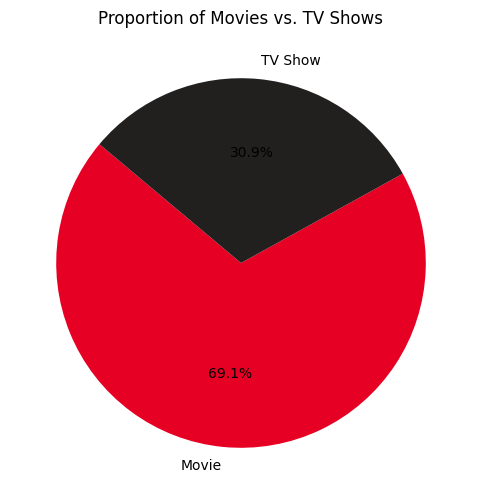

In [19]:
# Movies vs Shows
plt.figure(figsize=(8, 6))
type_counts = df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#e60023', '#221f1f'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

<Figure size 1400x800 with 0 Axes>

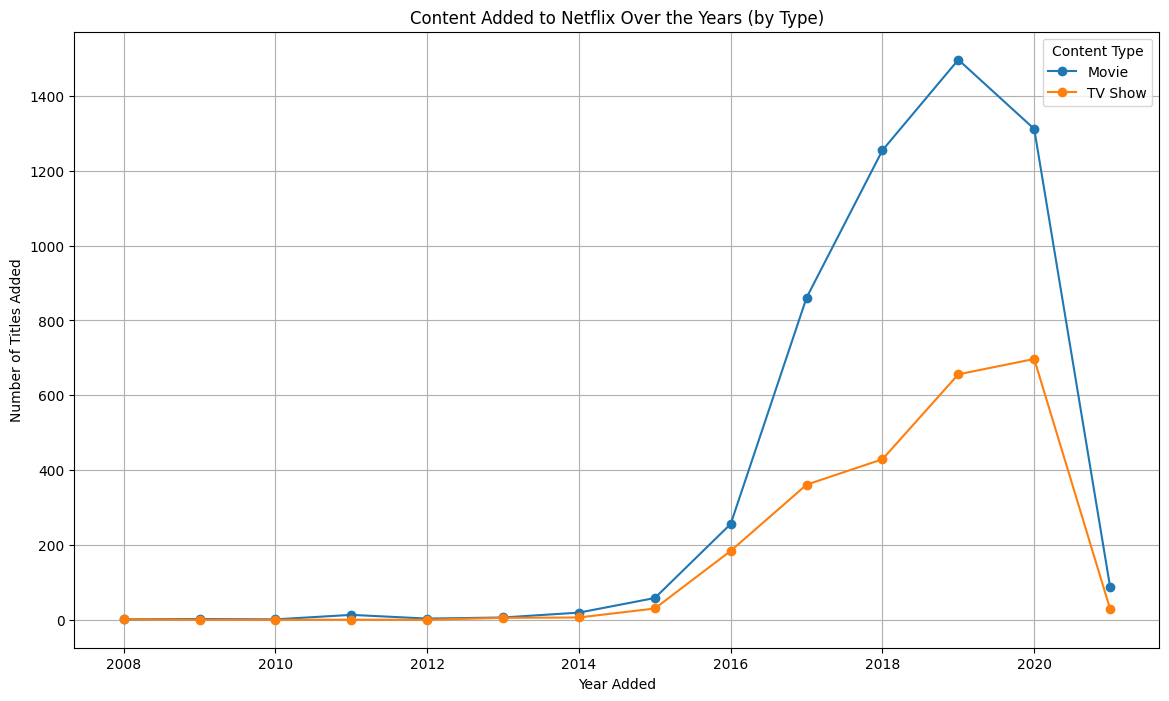

In [21]:
## Growth over the years
content_over_time = df.groupby(['year_added', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
content_over_time.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

##### Distribution

In [22]:
movies_df = df[df['type'] == 'Movie'].copy()
tv_shows_df = df[df['type'] == 'TV Show'].copy()

In [23]:
# Duration in minutes
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Seasons
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

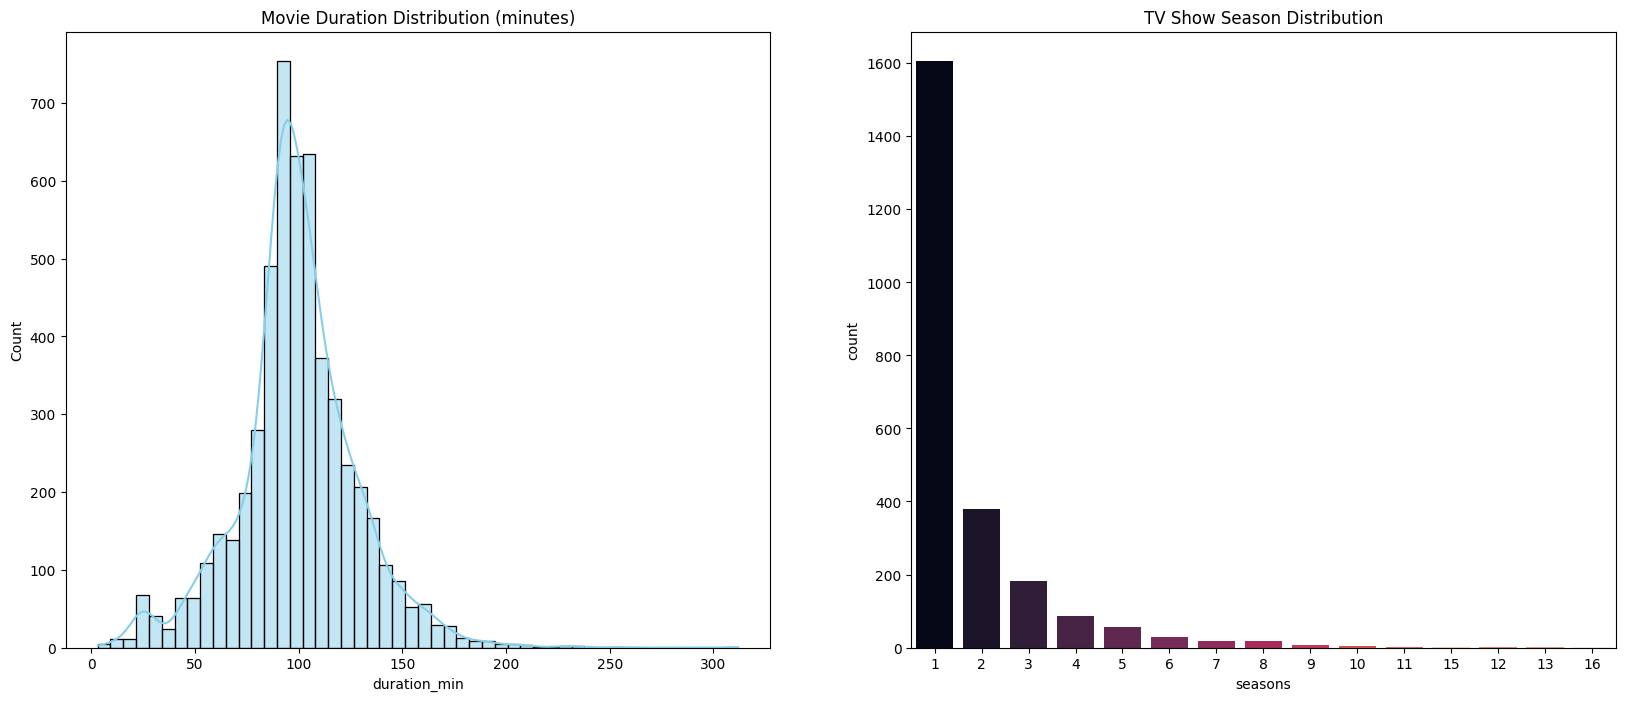

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')
# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

### Feature Extraction

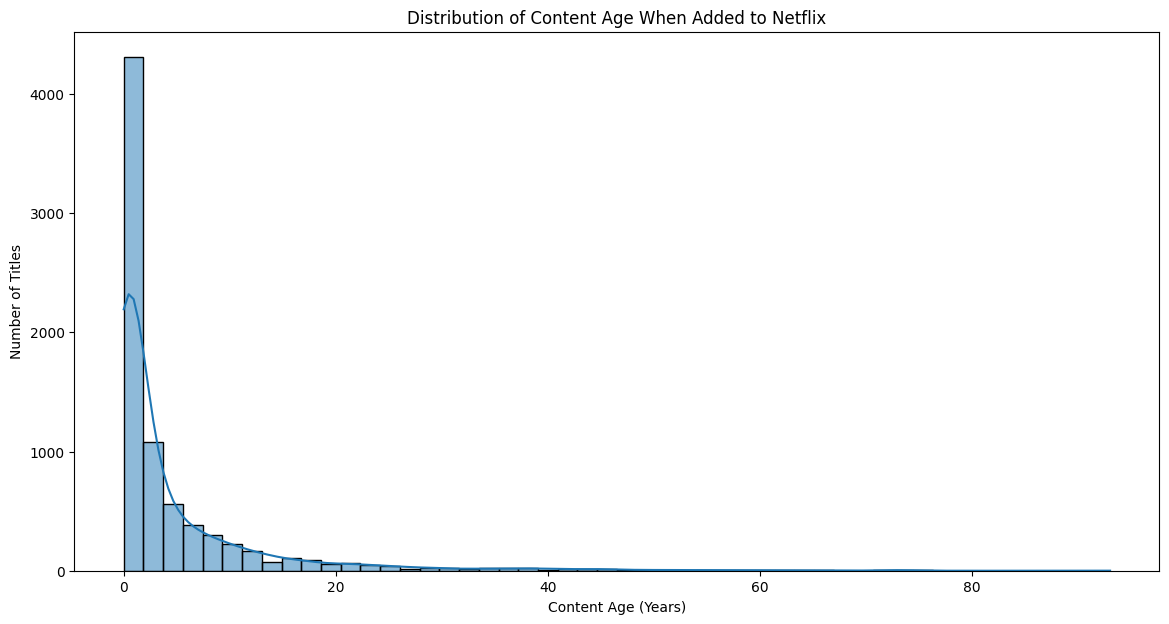

In [26]:
df['age_on_netflix'] = df['year_added'] - df['release_year']

# Filter out any potential errors where added_year is before release_year
content_age = df[df['age_on_netflix'] >= 0]

plt.figure(figsize=(14, 7))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age When Added to Netflix')
plt.xlabel('Content Age (Years)')
plt.ylabel('Number of Titles')
plt.show()

In [29]:
genres = df.assign(genre=df['listed_in'].str.split(', ')).explode('genre')

In [30]:
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count']

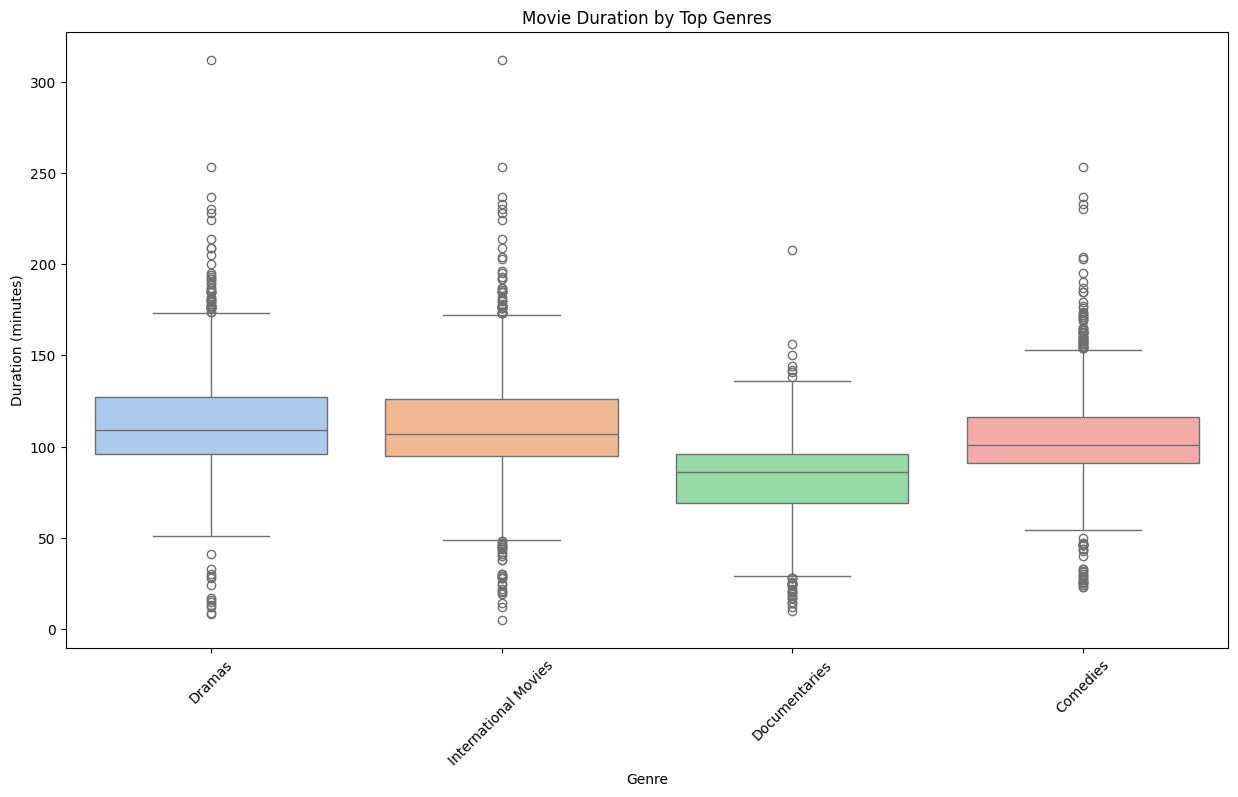

In [34]:
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(15, 8))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

### Word Cloud

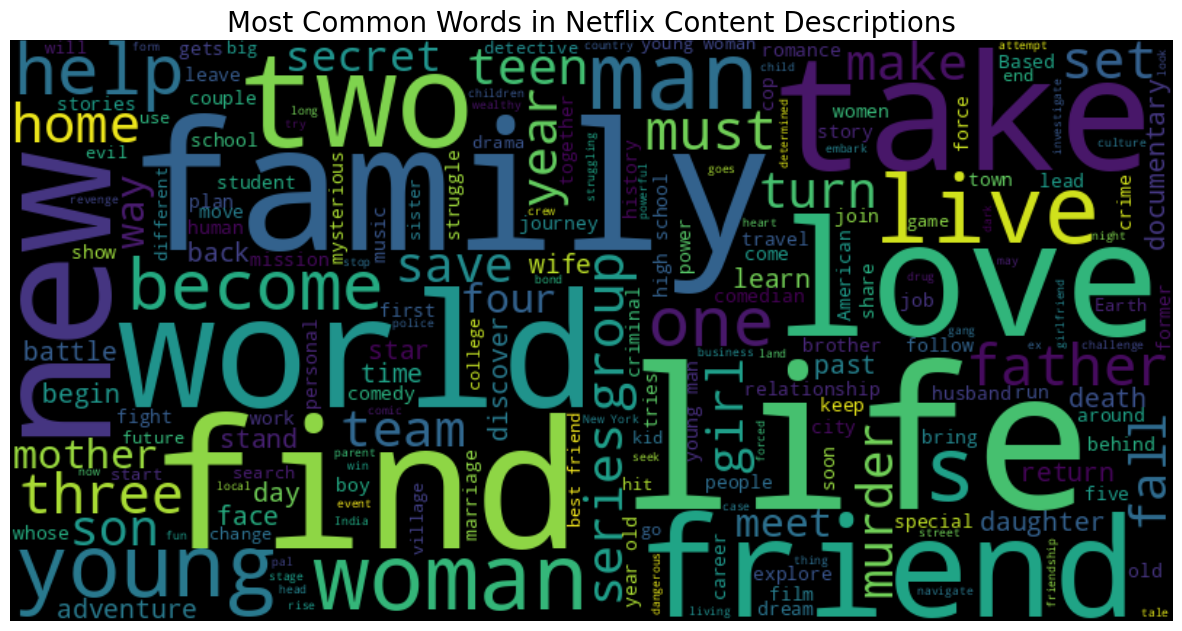

In [35]:
# Most common words
text = ' '.join(df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()

### Submission

#### Question 1: How has the distribution of content ratings changed over time?

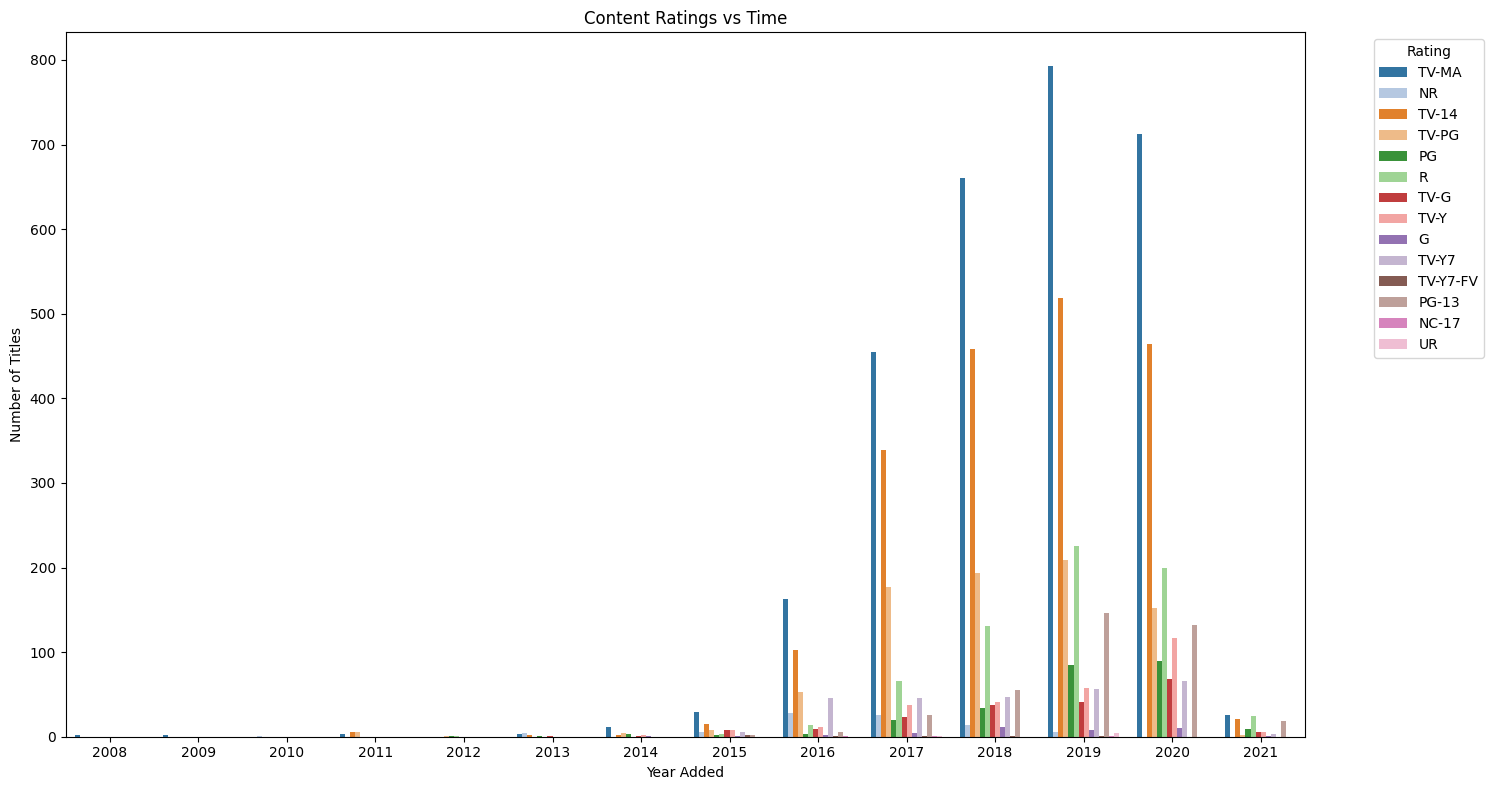

In [39]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='year_added', hue='rating', order=sorted(df['year_added'].unique()), palette='tab20')
plt.title('Content Ratings vs Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Question 2: Is there a relationship between content age and its type (Movie vs. TV Show)?

Content Age vs Type Relationship:
type         Movie  TV Show   All
age_group                        
0-5 years     2254      872  3126
6-10 years     615      188   803
11-20 years    510       82   592
21-50 years    334       32   366
50+ years       45        3    48
All           3758     1177  4935


<Figure size 1200x800 with 0 Axes>

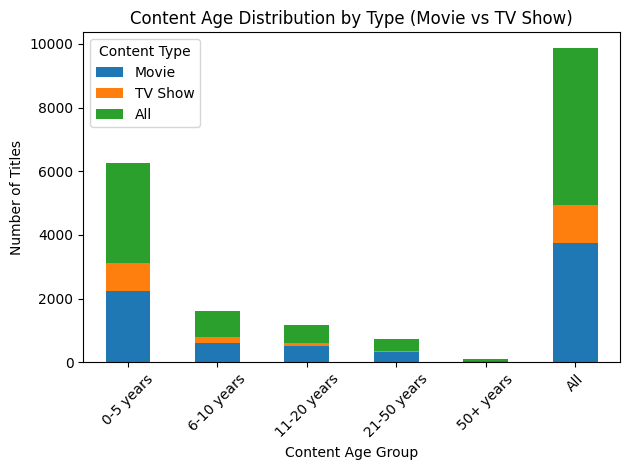

In [40]:
df['content_age'] = df['date_added'].dt.year - df['release_year']


df['age_group'] = pd.cut(df['content_age'], 
                        bins=[0, 5, 10, 20, 50, 100], 
                        labels=['0-5 years', '6-10 years', '11-20 years', '21-50 years', '50+ years'])


age_type_relationship = pd.crosstab(df['age_group'], df['type'], margins=True)
print("Content Age vs Type Relationship:")
print(age_type_relationship)

# Visualization
plt.figure(figsize=(12, 8))
age_type_relationship.plot(kind='bar', stacked=True)
plt.title('Content Age Distribution by Type (Movie vs TV Show)')
plt.xlabel('Content Age Group')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.legend(title='Content Type')
plt.tight_layout()
plt.show()


#### Question 3: Can we identify any trends in content production based on the release year vs. the year added to Netflix?

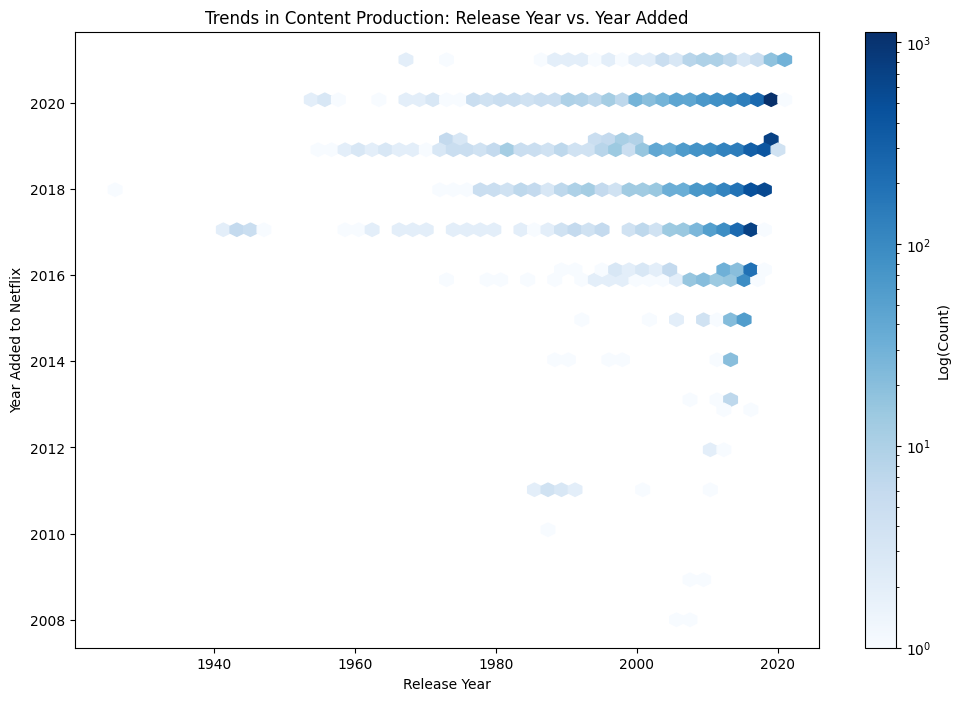

In [43]:
plt.figure(figsize=(12, 8))
plt.hexbin(
    df['release_year'], df['year_added'],
    gridsize=50, cmap='Blues', bins='log'
)
plt.colorbar(label='Log(Count)')
plt.xlabel('Release Year')
plt.ylabel('Year Added to Netflix')
plt.title('Trends in Content Production: Release Year vs. Year Added')
plt.show()




#### Question 4: What are the most common word pairs or phrases in content descriptions?

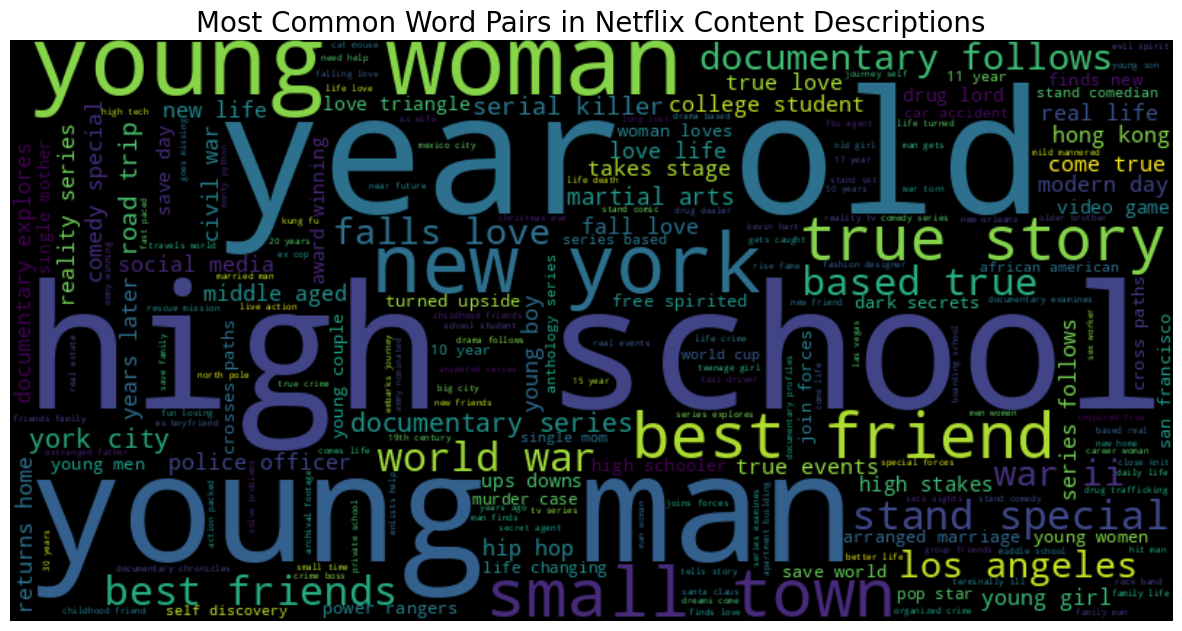

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

text = ' '.join(df['description'].dropna().astype(str))


vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit([text])
X = vectorizer.transform([text])


freqs = dict(zip(vectorizer.get_feature_names_out(), X.toarray()[0]))

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(freqs)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Word Pairs in Netflix Content Descriptions', fontsize=20)
plt.show()

#### Question 5: Who are the top directors

C:\Users\Akshat\AppData\Local\Temp\ipykernel_45608\3662588051.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Director', x='Number of Titles', data=top_directors.head(20), palette='BuPu')


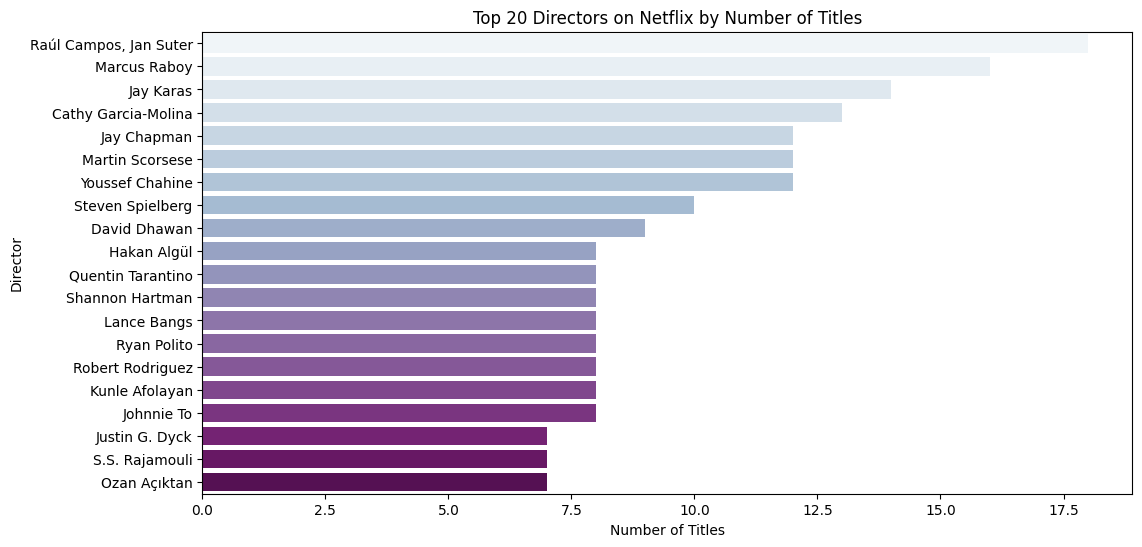

In [49]:
top_directors = (df['director'][df['director'] != 'Unknown'].value_counts().head(25).reset_index())

top_directors.columns = ['Director', 'Number of Titles']


plt.figure(figsize=(12, 6))
sns.barplot(y='Director', x='Number of Titles', data=top_directors.head(20), palette='BuPu')
plt.title('Top 20 Directors on Netflix by Number of Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.show()